# 参数配置

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

D:\Anaconda\envs\syftpy\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\envs\syftpy\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
D:\Anaconda\envs\syftpy\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
import syft as sy
import copy
hook = sy.TorchHook(torch)

In [3]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [4]:
# create a couple workers
bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")
secure_worker_a = sy.VirtualWorker(hook, id="secure_worker_a")
secure_worker_b = sy.VirtualWorker(hook, id="secure_worker_b")

In [5]:
# 

In [6]:
# transforms
train_transforms = transforms.Compose([#transforms.RandomRotation(30),
                                       # transforms.RandomResizedCrop(224),
                                       # transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5,], [0.5,])]) # mean, std
 

test_transforms = transforms.Compose([#transforms.Resize(255),
                                      #transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5,], [0.5,])]) # mean, std


# choose the training and test datasets

federated_train_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
    datasets.CIFAR100('/home/zhaojia-raoxy/data', train=True, download=True,
                   transform=train_transforms)
    .federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=20, shuffle=True, **kwargs)


federated_test_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
    datasets.CIFAR100('/home/zhaojia-raoxy/data', train=False, download=True,
                   transform=test_transforms)
    .federate((secure_worker_a, secure_worker_b)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=20, shuffle=False, **kwargs)

Files already downloaded and verified


Files already downloaded and verified


# ResNet18

In [9]:
model_name = '/home/zhaojia-raoxy/model/resnet18-5c106cde.pth'

def ResNet_s(args):
    ''':cvar
    返回修改好的模型，和冻结好的参数
    '''
    from torchvision.models import resnet18
    pretrain_model = resnet18(pretrained=False)
    pretrain_model.fc = nn.Linear(pretrain_model.fc.in_features, 100)  # 将全连接层改为自己想要的分类输出
    pretrained_dict = torch.load(model_name)

    pretrained_dict.pop('fc.weight')
    pretrained_dict.pop('fc.bias')

    model_dict = pretrain_model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

    model_dict.update(pretrained_dict)  # 模型参数列表进行参数更新，加载参数
    pretrain_model.load_state_dict(model_dict)  # 将满足条件的参数的 requires_grad 属性设置为False

#     for name, value in pretrain_model.named_parameters():
#         if (name != 'fc.weight') and (name != 'fc.bias'):
#             value.requires_grad = False
    params_conv = filter(lambda p: p.requires_grad, pretrain_model.parameters())  # 要更新的参数在parms_conv当中
    return pretrain_model, params_conv

model, params_conv = ResNet_s(model_name)
model = model.to(device)
optimizer = optim.SGD(params_conv, lr=0.03) # TODO momentum is not supported at the moment

# 训练

In [10]:
criterion = nn.CrossEntropyLoss().to(device)
loss_train=[]
acc_train=[]
loss2=[]

def train(model, device, federated_train_loader, optimizer, epoch, batch_size):
    global criterion
    model.train()
   
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        model.send(data.location) # <-- NEW: send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.long())
#         loss = F.cross_entropy(output, target.long())
#         loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        model.get() # <-- NEW: get the model back
        
        if batch_idx % 2000 == 0:
            loss = loss.get() # <-- NEW: get the loss
            # loss_train.append(loss.item())
            # acc_train.append()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(federated_train_loader) * batch_size,
                100. * batch_idx / len(federated_train_loader), loss.item()))

In [11]:
def test(model, device, federated_test_loader, batch_size): 
    global criterion
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in federated_test_loader:
            model.send(data.location) # <-- NEW: send the model in virtual workers to Trusted Aggregator
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target.long())
#             loss = F.nll_loss(output, target, reduction='sum')
            model.get()
            test_loss += loss.get() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().get()

    test_loss /= len(federated_test_loader)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(federated_test_loader) * batch_size,
        100. * correct / len(federated_test_loader) / batch_size))

In [12]:
for epoch in range(50):
    train(model, device, federated_train_loader, optimizer, epoch, batch_size=20)
    test(model, device, federated_test_loader, batch_size=20)

Train Epoch: 0 [0/50000 (0%)]	Loss: 4.720592
Train Epoch: 0 [40000/50000 (80%)]	Loss: 4.598782

Test set: Average loss: 0.0170, Accuracy: 100/10000 (1%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 4.611238
Train Epoch: 1 [40000/50000 (80%)]	Loss: 4.596069

Test set: Average loss: -0.0003, Accuracy: 100/10000 (1%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 4.616010
Train Epoch: 2 [40000/50000 (80%)]	Loss: 4.607326

Test set: Average loss: -0.0085, Accuracy: 100/10000 (1%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 4.606952
Train Epoch: 3 [40000/50000 (80%)]	Loss: 4.606687

Test set: Average loss: -0.0124, Accuracy: 100/10000 (1%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 4.607386
Train Epoch: 4 [40000/50000 (80%)]	Loss: 4.604627

Test set: Average loss: -0.0155, Accuracy: 100/10000 (1%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 4.608023
Train Epoch: 5 [40000/50000 (80%)]	Loss: 4.605054

Test set: Average loss: -0.0176, Accuracy: 100/10000 (1%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 4.604144
Train Epoch: 6 [40000/5000

KeyboardInterrupt: 

# 结果保存

In [ ]:
save_name='ResNet18'

In [ ]:
# 保存模型的权重
torch.save(model.state_dict(), "/home/zhaojia-raoxy/model/out/{}.pt".format(save_name))
print("保存文件：","/home/zhaojia-raoxy/model/out/{}.pt".format(save_name))

In [ ]:
# 保存整个模型
torch.save(model, "/home/zhaojia-raoxy/model/out/{}.h5".format(save_name))
print("保存文件：","/home/zhaojia-raoxy/model/out/{}.h5".format(save_name))

# 分析

In [1]:
txt='''
Train Epoch: 0 [0/50000 (0%)]	Loss: 4.633727
Train Epoch: 0 [40000/50000 (80%)]	Loss: 3.009759

Test set: Average loss: 2.5777, Accuracy: 3431/10000 (34%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.605472
Train Epoch: 1 [40000/50000 (80%)]	Loss: 3.164638

Test set: Average loss: 2.2362, Accuracy: 4156/10000 (42%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.315158
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.508186

Test set: Average loss: 2.0496, Accuracy: 4597/10000 (46%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.269127
Train Epoch: 3 [40000/50000 (80%)]	Loss: 1.577307

Test set: Average loss: 2.0541, Accuracy: 4616/10000 (46%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 2.074335
Train Epoch: 4 [40000/50000 (80%)]	Loss: 1.671571

Test set: Average loss: 2.1051, Accuracy: 4601/10000 (46%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.700276
Train Epoch: 5 [40000/50000 (80%)]	Loss: 1.627525

Test set: Average loss: 2.0766, Accuracy: 4815/10000 (48%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.731983
Train Epoch: 6 [40000/50000 (80%)]	Loss: 1.722926

Test set: Average loss: 2.1611, Accuracy: 4869/10000 (49%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.057383
Train Epoch: 7 [40000/50000 (80%)]	Loss: 1.208957

Test set: Average loss: 2.2301, Accuracy: 4823/10000 (48%)

Train Epoch: 8 [0/50000 (0%)]	Loss: 1.050695
Train Epoch: 8 [40000/50000 (80%)]	Loss: 0.898730

Test set: Average loss: 2.2776, Accuracy: 4746/10000 (47%)

Train Epoch: 9 [0/50000 (0%)]	Loss: 0.155214
Train Epoch: 9 [40000/50000 (80%)]	Loss: 0.856169

Test set: Average loss: 2.3998, Accuracy: 4751/10000 (48%)

Train Epoch: 10 [0/50000 (0%)]	Loss: 0.720880
Train Epoch: 10 [40000/50000 (80%)]	Loss: 0.755177

Test set: Average loss: 2.4699, Accuracy: 4666/10000 (47%)

Train Epoch: 11 [0/50000 (0%)]	Loss: 0.695577
Train Epoch: 11 [40000/50000 (80%)]	Loss: 0.913222

Test set: Average loss: 2.8948, Accuracy: 4365/10000 (44%)

Train Epoch: 12 [0/50000 (0%)]	Loss: 1.026237
Train Epoch: 12 [40000/50000 (80%)]	Loss: 0.471459

Test set: Average loss: 2.6567, Accuracy: 4672/10000 (47%)

Train Epoch: 13 [0/50000 (0%)]	Loss: 1.048628
Train Epoch: 13 [40000/50000 (80%)]	Loss: 0.416610

Test set: Average loss: 2.8359, Accuracy: 4615/10000 (46%)

Train Epoch: 14 [0/50000 (0%)]	Loss: 0.372979
Train Epoch: 14 [40000/50000 (80%)]	Loss: 0.226143

Test set: Average loss: 2.7777, Accuracy: 4505/10000 (45%)

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.342643
Train Epoch: 15 [40000/50000 (80%)]	Loss: 0.657099

Test set: Average loss: 2.9822, Accuracy: 4463/10000 (45%)

Train Epoch: 16 [0/50000 (0%)]	Loss: 1.036852
Train Epoch: 16 [40000/50000 (80%)]	Loss: 1.255530

Test set: Average loss: 2.8759, Accuracy: 4364/10000 (44%)

Train Epoch: 17 [0/50000 (0%)]	Loss: 0.136825
Train Epoch: 17 [40000/50000 (80%)]	Loss: 0.796144

Test set: Average loss: 3.0588, Accuracy: 4357/10000 (44%)

Train Epoch: 18 [0/50000 (0%)]	Loss: 0.417500
Train Epoch: 18 [40000/50000 (80%)]	Loss: 0.399545

Test set: Average loss: 3.2108, Accuracy: 4322/10000 (43%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.682538
Train Epoch: 19 [40000/50000 (80%)]	Loss: 0.904679

Test set: Average loss: 3.0751, Accuracy: 4304/10000 (43%)

Train Epoch: 20 [0/50000 (0%)]	Loss: 0.524358
Train Epoch: 20 [40000/50000 (80%)]	Loss: 0.215023

Test set: Average loss: 3.2209, Accuracy: 4406/10000 (44%)

Train Epoch: 21 [0/50000 (0%)]	Loss: 0.825412
Train Epoch: 21 [40000/50000 (80%)]	Loss: 0.442941

Test set: Average loss: 3.0964, Accuracy: 4389/10000 (44%)

Train Epoch: 22 [0/50000 (0%)]	Loss: 0.615743
Train Epoch: 22 [40000/50000 (80%)]	Loss: 0.370848

Test set: Average loss: 3.2387, Accuracy: 4358/10000 (44%)

Train Epoch: 23 [0/50000 (0%)]	Loss: 0.505105
Train Epoch: 23 [40000/50000 (80%)]	Loss: 0.406642

Test set: Average loss: 3.3864, Accuracy: 4278/10000 (43%)

Train Epoch: 24 [0/50000 (0%)]	Loss: 0.833782
Train Epoch: 24 [40000/50000 (80%)]	Loss: 0.613278

Test set: Average loss: 3.5733, Accuracy: 4320/10000 (43%)

Train Epoch: 25 [0/50000 (0%)]	Loss: 0.428190
Train Epoch: 25 [40000/50000 (80%)]	Loss: 0.627136

Test set: Average loss: 3.4211, Accuracy: 4368/10000 (44%)

Train Epoch: 26 [0/50000 (0%)]	Loss: 0.638523
Train Epoch: 26 [40000/50000 (80%)]	Loss: 0.489780

Test set: Average loss: 3.4766, Accuracy: 4312/10000 (43%)

Train Epoch: 27 [0/50000 (0%)]	Loss: 0.213765
Train Epoch: 27 [40000/50000 (80%)]	Loss: 0.234051

Test set: Average loss: 3.5131, Accuracy: 4054/10000 (41%)

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.842071
Train Epoch: 28 [40000/50000 (80%)]	Loss: 0.353602

Test set: Average loss: 3.5367, Accuracy: 4082/10000 (41%)

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.495031
Train Epoch: 29 [40000/50000 (80%)]	Loss: 0.298019

Test set: Average loss: 3.6907, Accuracy: 4203/10000 (42%)

Train Epoch: 30 [0/50000 (0%)]	Loss: 0.981033
Train Epoch: 30 [40000/50000 (80%)]	Loss: 0.251467

Test set: Average loss: 3.7156, Accuracy: 4192/10000 (42%)

Train Epoch: 31 [0/50000 (0%)]	Loss: 0.665172
Train Epoch: 31 [40000/50000 (80%)]	Loss: 0.334525

Test set: Average loss: 3.7727, Accuracy: 3958/10000 (40%)

Train Epoch: 32 [0/50000 (0%)]	Loss: 0.444795
Train Epoch: 32 [40000/50000 (80%)]	Loss: 0.449015

Test set: Average loss: 3.9372, Accuracy: 4154/10000 (42%)

Train Epoch: 33 [0/50000 (0%)]	Loss: 0.440047
Train Epoch: 33 [40000/50000 (80%)]	Loss: 0.603736

Test set: Average loss: 3.8023, Accuracy: 4211/10000 (42%)

Train Epoch: 34 [0/50000 (0%)]	Loss: 0.454635
Train Epoch: 34 [40000/50000 (80%)]	Loss: 0.246743

Test set: Average loss: 3.8423, Accuracy: 4068/10000 (41%)

Train Epoch: 35 [0/50000 (0%)]	Loss: 0.158758
Train Epoch: 35 [40000/50000 (80%)]	Loss: 0.410959

Test set: Average loss: 3.7671, Accuracy: 4194/10000 (42%)

Train Epoch: 36 [0/50000 (0%)]	Loss: 0.352883
Train Epoch: 36 [40000/50000 (80%)]	Loss: 0.183339

Test set: Average loss: 4.0523, Accuracy: 4102/10000 (41%)

Train Epoch: 37 [0/50000 (0%)]	Loss: 0.658083
Train Epoch: 37 [40000/50000 (80%)]	Loss: 0.653031

Test set: Average loss: 4.0752, Accuracy: 4021/10000 (40%)

Train Epoch: 38 [0/50000 (0%)]	Loss: 0.380170
Train Epoch: 38 [40000/50000 (80%)]	Loss: 0.186936

Test set: Average loss: 4.0785, Accuracy: 4107/10000 (41%)

Train Epoch: 39 [0/50000 (0%)]	Loss: 0.563175
Train Epoch: 39 [40000/50000 (80%)]	Loss: 0.820416

Test set: Average loss: 3.9969, Accuracy: 4107/10000 (41%)

Train Epoch: 40 [0/50000 (0%)]	Loss: 0.125875
Train Epoch: 40 [40000/50000 (80%)]	Loss: 0.134189

Test set: Average loss: 3.7609, Accuracy: 4107/10000 (41%)

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.748340
Train Epoch: 41 [40000/50000 (80%)]	Loss: 0.758812

Test set: Average loss: 4.2059, Accuracy: 4008/10000 (40%)

Train Epoch: 42 [0/50000 (0%)]	Loss: 0.077800
Train Epoch: 42 [40000/50000 (80%)]	Loss: 1.059544

Test set: Average loss: 4.1770, Accuracy: 4001/10000 (40%)

Train Epoch: 43 [0/50000 (0%)]	Loss: 0.856999
Train Epoch: 43 [40000/50000 (80%)]	Loss: 0.659375

Test set: Average loss: 3.9793, Accuracy: 3972/10000 (40%)

Train Epoch: 44 [0/50000 (0%)]	Loss: 0.328441
Train Epoch: 44 [40000/50000 (80%)]	Loss: 0.191952

Test set: Average loss: 4.0916, Accuracy: 3998/10000 (40%)

Train Epoch: 45 [0/50000 (0%)]	Loss: 0.633182
Train Epoch: 45 [40000/50000 (80%)]	Loss: 0.536928

Test set: Average loss: 4.0618, Accuracy: 4035/10000 (40%)

Train Epoch: 46 [0/50000 (0%)]	Loss: 0.503070
Train Epoch: 46 [40000/50000 (80%)]	Loss: 0.316466

Test set: Average loss: 4.1943, Accuracy: 4086/10000 (41%)

Train Epoch: 47 [0/50000 (0%)]	Loss: 0.538570
Train Epoch: 47 [40000/50000 (80%)]	Loss: 0.975473

Test set: Average loss: 4.3781, Accuracy: 4021/10000 (40%)

Train Epoch: 48 [0/50000 (0%)]	Loss: 0.025751
Train Epoch: 48 [40000/50000 (80%)]	Loss: 0.323089

Test set: Average loss: 4.2746, Accuracy: 3988/10000 (40%)

Train Epoch: 49 [0/50000 (0%)]	Loss: 0.137911
Train Epoch: 49 [40000/50000 (80%)]	Loss: 0.101982

Test set: Average loss: 4.1405, Accuracy: 3968/10000 (40%)
'''

In [2]:
loss=[]
acc=[]
loss2=[]

for i in txt.split('\n'):
     if len(i)>0:
        if '40000/50000 ' in i:
            loss.append(float(i.split()[-1].strip()))
        if 'Test' in i:
            loss2.append(float(i.split()[4].strip().replace(",", "")))
            acc.append(float(i.split()[-2].split('/')[0])/10000)

D:\Anaconda\envs\syftpy\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\envs\syftpy\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
D:\Anaconda\envs\syftpy\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


<IPython.core.display.Javascript object>


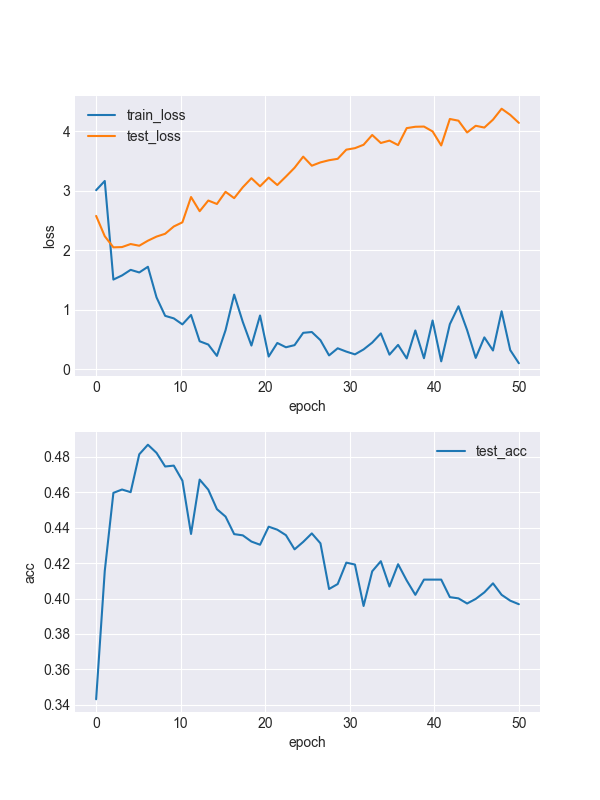

In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt

mpl.use('nbAgg')
mpl.style.use('seaborn-darkgrid')
import numpy as np
def plotP(test_loss, train_loss, train_acc_list, test_acc_list):
    plt.figure(figsize=(6, 8))
    x = np.linspace(0,  len(train_loss))
    y = np.linspace(0, len(test_acc_list))
    plt.subplot(2, 1, 1)
    plt.plot(x, train_loss, label="train_loss")
    plt.plot(x, test_loss, label="test_loss")

    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(y, test_acc_list, label="test_acc")
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.legend()
    plt.show()

plotP(loss2, loss, [], acc)